In [19]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.distributions.uniform import Uniform
from torch.utils.data import TensorDataset, DataLoader

# HuggingFace
import datasets

# Transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [35]:
# Load train, validation, and test data
train_data, validation_data, test_data = datasets.load_dataset("rotten_tomatoes",
                                                               split=["train", "validation", "test"])
train_data, validation_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 8530
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }))

In [36]:
# Changing train data into df form
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(validation_data)
train_df

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young woman's b...,0
8528,"interminably bleak , to say nothing of boring .",0


## Data Preparation

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# Example Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize text
        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Train and test data
train_texts = train_df['text']
train_labels = train_df['label']
val_texts = val_df['text']
val_labels = val_df['label']

# Tokenizer and Dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_length=256)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_length=256)

# DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)

# Utilize GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Neural Network

In [31]:
from transformers import BertModel
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # CLS token representation
        output = self.dropout(pooled_output)
        return self.fc(output)

model = SentimentClassifier(n_classes=2)
#model = model.to(device)

In [38]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize dictionaries to store metrics
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

def train_and_evaluate_model(model, train_loader, val_loader, optimizer, loss_fn, epochs, device):
    model.to(device)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Training Phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        train_batches = len(train_loader)

        # Live tracking using tqdm
        pbar = tqdm(train_loader, desc="Training", leave=False)
        for batch_idx, batch in enumerate(pbar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = loss_fn(outputs, labels)
            train_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # Compute running accuracy
            running_accuracy = train_correct / train_total
            running_loss = train_loss / (batch_idx + 1)

            # Update progress bar description
            pbar.set_description(f"Training: Loss {running_loss:.4f} | Acc {running_accuracy:.4f}")

            loss.backward()
            optimizer.step()

        # Epoch-level metrics
        epoch_train_loss = train_loss / train_batches
        epoch_train_accuracy = train_correct / train_total
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_accuracy)

        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_batches = len(val_loader)
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation", leave=False):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # Epoch-level metrics
        epoch_val_loss = val_loss / val_batches
        epoch_val_accuracy = val_correct / val_total
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_accuracy)

        print(f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    return history


In [33]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Epoch 1/3


Train Loss: 0.4126, Train Accuracy: 0.8168


Val Loss: 0.3558, Val Accuracy: 0.8508
Epoch 2/3


Train Loss: 0.2105, Train Accuracy: 0.9216


Val Loss: 0.4903, Val Accuracy: 0.8143
Epoch 3/3


Train Loss: 0.0947, Train Accuracy: 0.9693


Val Loss: 0.5087, Val Accuracy: 0.8462


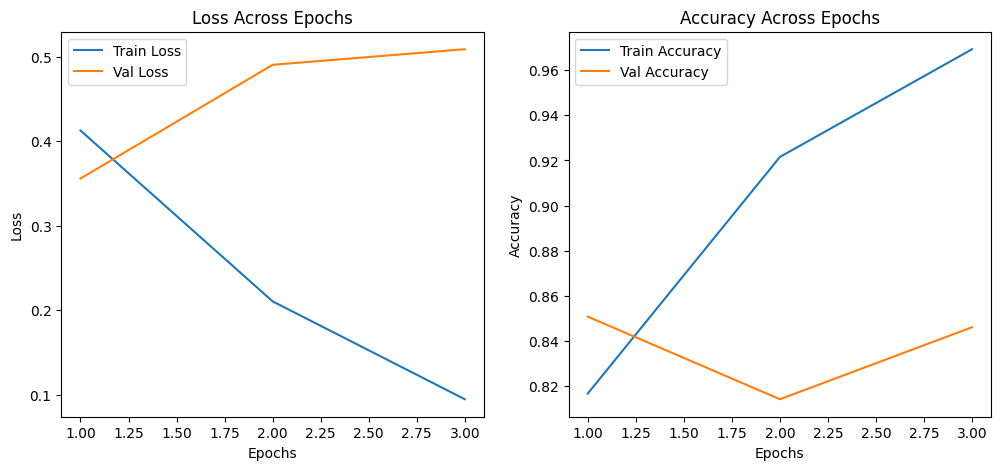

In [39]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train and evaluate
history = train_and_evaluate_model(model, dataloader, val_loader, optimizer, loss_fn, epochs=3, device=device)

# Plot metrics
plot_metrics(history)

## Testing

In [40]:
def test_model(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())

    return predictions

## Running the Pipeline

In [ ]:
test_df = pd.DataFrame(test_data)
test_texts = test_df['text']
test_labels = test_df['label']

test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_length=256)

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

# Test the model (on a separate test DataLoader)
predictions = test_model(model, test_loader)

In [44]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(accuracy_score(test_df['label'], predictions))
print(classification_report(test_df['label'], predictions))
print(confusion_matrix(test_df['label'], predictions))

0.5159474671669794
              precision    recall  f1-score   support

           0       0.52      0.47      0.50       533
           1       0.51      0.56      0.54       533

    accuracy                           0.52      1066
   macro avg       0.52      0.52      0.52      1066
weighted avg       0.52      0.52      0.52      1066

[[253 280]
 [236 297]]
